# Interactive Flight Route Map (Plotly)

This notebook provides an interactive world map of your flights using Plotly. It's a modern alternative to Basemap and works well inside JupyterLab/Notebook.

Usage: run all cells, paste or upload routes (one per line, e.g. `HKG,HGH`), then click **Draw**. The map is interactive (pan/zoom, hover).

In [13]:
# Imports
from collections import Counter
import re
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
print('Plotly version:', pd.__version__)
# Static Flight Route Map (Basemap)
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from collections import Counter

Plotly version: 2.3.2


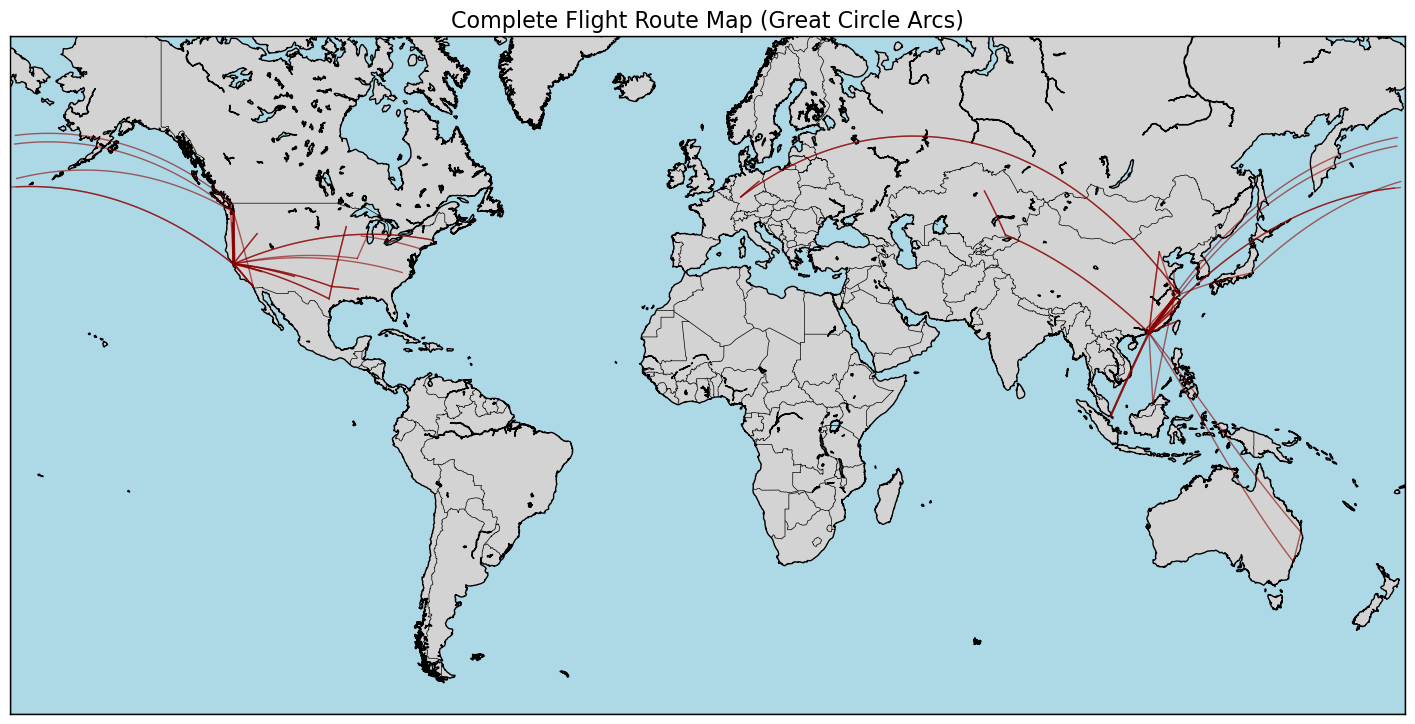

In [ ]:
# STEP 1: Import all routes from CSV
import pandas as pd
full_routes = []
try:
    df = pd.read_csv('data/my_flight_log.csv')
    for _, row in df.iterrows():
        o = str(row['origin']).strip().upper()
        d = str(row['destination']).strip().upper()
        if o and d:
            full_routes.append((o, d))
except Exception as e:
    print(f"Error reading routes: {e}")

# STEP 2: Define coordinates for all involved airports
airport_coords = {
    "HGH": (120.4333, 30.2295), "HKG": (113.9185, 22.3080), "BNE": (153.1094, -27.3842),
    "SYD": (151.1772, -33.9461), "PVG": (121.8052, 31.1443), "FRA": (8.5706, 50.0333),
    "TXL": (13.2877, 52.5597), "SIN": (103.9894, 1.3644), "PEK": (116.5975, 40.0801),
    "ALA": (76.8844, 43.3521), "NQZ": (71.4669, 51.0222), "SFO": (-122.375, 37.6189),
    "LAX": (-118.4085, 33.9416), "RDU": (-78.7875, 35.8776), "EWR": (-74.1745, 40.6895),
    "MSN": (-89.3375, 43.1399), "MKE": (-87.8966, 42.9481), "STL": (-90.3700, 38.7487),
    "SEA": (-122.3093, 47.4502), "OAK": (-122.221, 37.7126), "SAN": (-117.1897, 32.7336),
    "SJC": (-121.9290, 37.3627), "PDX": (-122.5975, 45.5898), "BOI": (-116.2228, 43.5644),
    "BOS": (-71.0052, 42.3656), "LAS": (-115.1523, 36.0833), "TPE": (121.2325, 25.0777),
    "DFW": (-97.0403, 32.8998), "JAN": (-90.0759, 32.3112), "YVR": (-123.1830, 49.1951),
    "TAO": (120.3744, 36.2661), "WNZ": (120.8530, 27.9122), "CAN": (113.2988, 23.3924),
    "SZX": (113.8107, 22.6393), "NRT": (140.3929, 35.7668), "BWN": (114.9283, 4.9442),
    "MFM": (113.5925, 22.1496), "ABQ": (-106.6092, 35.0496), "MSP": (-93.2218, 44.8848),
    "AUS": (-97.6699, 30.1945), "IAH": (-95.3414, 29.9844), "HOU": (-95.2789, 29.6454),
    "MIA": (-80.2906, 25.7959), "JFK": (-73.7781, 40.6413), "LHR": (-0.4543, 51.4700),
    "MCO": (-81.3081, 28.4312)
}

# STEP 3: Count route frequencies
from collections import Counter
route_counts = Counter(full_routes)

# STEP 4: Create the map
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
plt.figure(figsize=(18, 10))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=70,
            llcrnrlon=-180, urcrnrlon=180, resolution='l')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# STEP 5: Plot routes using great circles with thickness based on frequency
for (origin, dest), count in route_counts.items():
    if origin in airport_coords and dest in airport_coords:
        lon1, lat1 = airport_coords[origin]
        lon2, lat2 = airport_coords[dest]
        try:
            m.drawgreatcircle(lon1, lat1, lon2, lat2,
                              linewidth=1 + 0.5 * (count - 1),
                              color='darkred', alpha=0.5 + 0.1 * min(count, 5))
        except:
            continue

plt.title("Complete Flight Route Map (Great Circle Arcs)", fontsize=16)
plt.show()


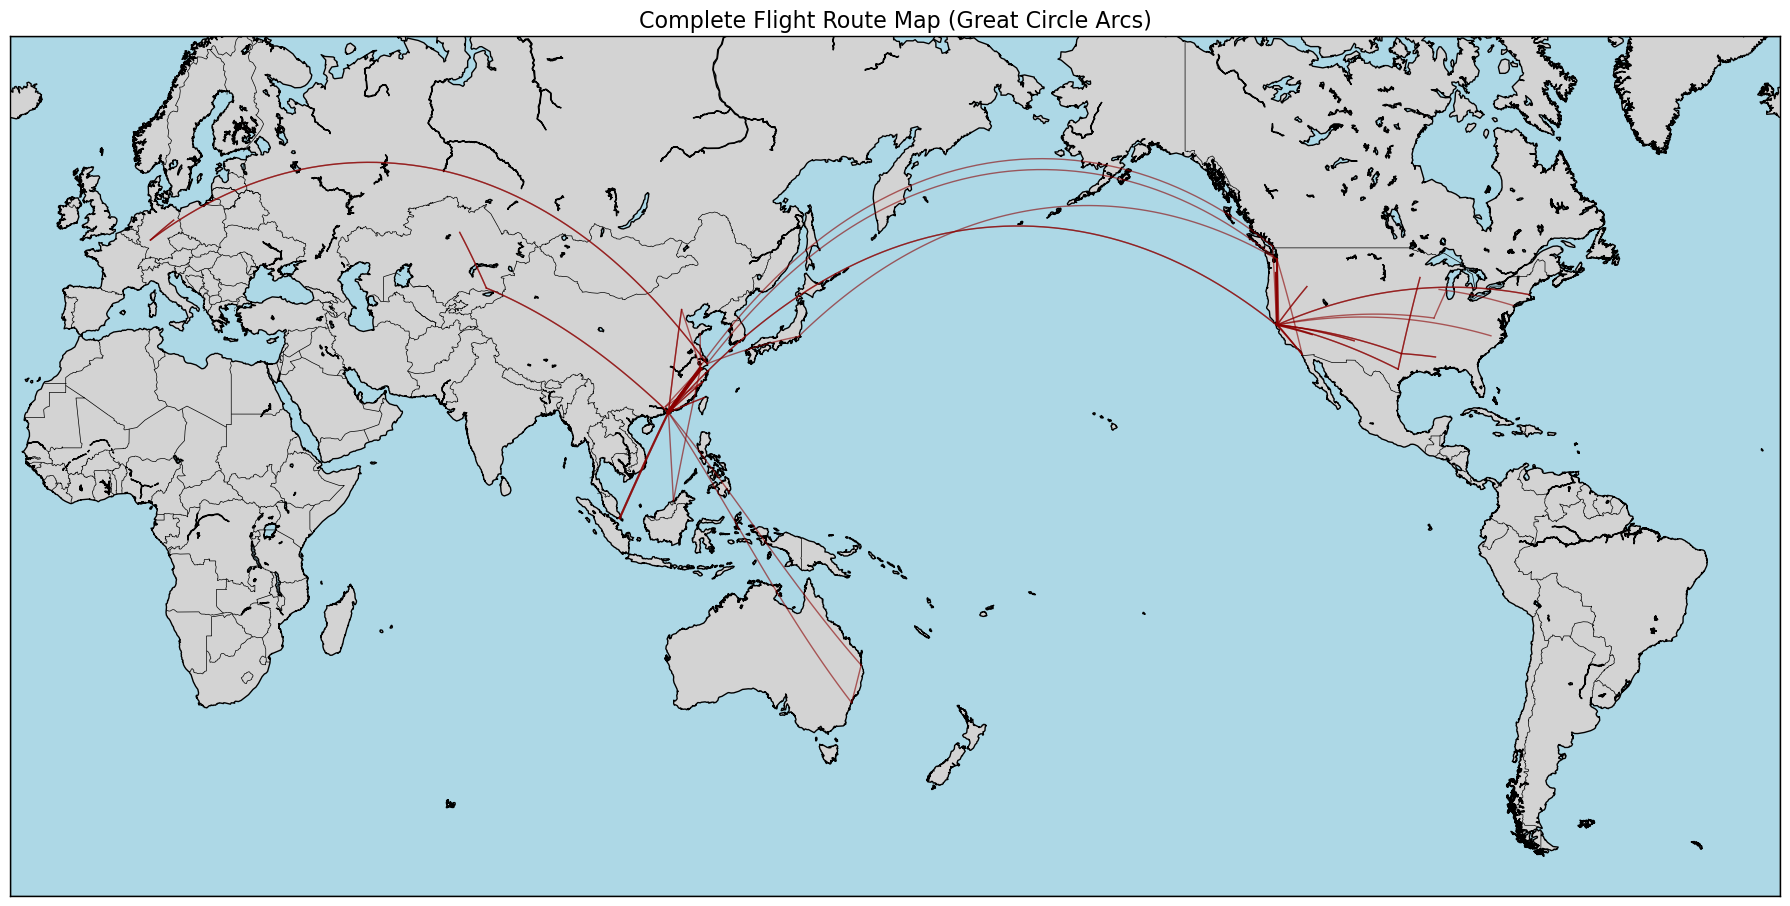

In [25]:
# -*- coding: utf-8 -*-
# Complete Pacific-centered flight map with great-circle routes
# - Mercator projection, same N–S extent
# - Seam at -20° so the Atlantic is the cut (US↔EU can be split),
#   while Pacific stays continuous (CHN↔US intact)

# STEP 0: Imports
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Geod

# STEP 1: Load routes from CSV  (expects columns: origin, destination)
full_routes = []
csv_path = 'data/my_flight_log.csv'
try:
    df = pd.read_csv(csv_path)
    for _, row in df.iterrows():
        o = str(row['origin']).strip().upper()
        d = str(row['destination']).strip().upper()
        if o and d and o != 'NAN' and d != 'NAN':
            full_routes.append((o, d))
except Exception as e:
    print(f"[WARN] Could not read '{csv_path}': {e}. Proceeding with any hardcoded routes if present.")

# STEP 2: Airport coordinates (lon, lat) — extend as needed
airport_coords = {
    "HGH": (120.4333, 30.2295), "HKG": (113.9185, 22.3080), "BNE": (153.1094, -27.3842),
    "SYD": (151.1772, -33.9461), "PVG": (121.8052, 31.1443), "FRA": (8.5706, 50.0333),
    "TXL": (13.2877, 52.5597), "SIN": (103.9894, 1.3644), "PEK": (116.5975, 40.0801),
    "ALA": (76.8844, 43.3521), "NQZ": (71.4669, 51.0222), "SFO": (-122.375, 37.6189),
    "LAX": (-118.4085, 33.9416), "RDU": (-78.7875, 35.8776), "EWR": (-74.1745, 40.6895),
    "MSN": (-89.3375, 43.1399), "MKE": (-87.8966, 42.9481), "STL": (-90.3700, 38.7487),
    "SEA": (-122.3093, 47.4502), "OAK": (-122.221, 37.7126), "SAN": (-117.1897, 32.7336),
    "SJC": (-121.9290, 37.3627), "PDX": (-122.5975, 45.5898), "BOI": (-116.2228, 43.5644),
    "BOS": (-71.0052, 42.3656), "LAS": (-115.1523, 36.0833), "TPE": (121.2325, 25.0777),
    "DFW": (-97.0403, 32.8998), "JAN": (-90.0759, 32.3112), "YVR": (-123.1830, 49.1951),
    "TAO": (120.3744, 36.2661), "WNZ": (120.8530, 27.9122), "CAN": (113.2988, 23.3924),
    "SZX": (113.8107, 22.6393), "NRT": (140.3929, 35.7668), "BWN": (114.9283, 4.9442),
    "MFM": (113.5925, 22.1496), "ABQ": (-106.6092, 35.0496), "MSP": (-93.2218, 44.8848),
    "AUS": (-97.6699, 30.1945), "IAH": (-95.3414, 29.9844), "HOU": (-95.2789, 29.6454),
}

# STEP 3: Count route frequencies (for line width/alpha)
route_counts = Counter(full_routes)

# STEP 4: Make a Pacific-centered Mercator map (same N–S extent)
plt.figure(figsize=(18, 10))
SEAM_LON = -20.0                 # Atlantic seam; Pacific is centered
m = Basemap(
    projection='merc',
    llcrnrlat=-60, urcrnrlat=70,
    llcrnrlon=SEAM_LON, urcrnrlon=340,   # [-20°, 340°] spans 360°
    resolution='l'
)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# STEP 5: Robust great-circle plotting with seam handling
geod = Geod(ellps='WGS84')

def to_minus180_180(lon):
    """Normalize longitude to [-180, 180)."""
    return ((lon + 180) % 360) - 180

def wrap_to_window(lon):
    """Wrap longitude to [SEAM_LON, SEAM_LON + 360)."""
    return ((lon - SEAM_LON) % 360) + SEAM_LON

def plot_gc_segmented(lon1, lat1, lon2, lat2, lw=1.0, alpha=0.6, npts=80):
    """
    Draw a great-circle line from (lon1, lat1) to (lon2, lat2),
    choosing the shortest geodesic in [-180,180),
    then wrapping to the Pacific-centered window and splitting at the seam.
    """
    lon1 = to_minus180_180(lon1)
    lon2 = to_minus180_180(lon2)

    # sample geodesic (npts excludes endpoints)
    pts = geod.npts(lon1, lat1, lon2, lat2, npts)
    lons = [lon1] + [p[0] for p in pts] + [lon2]
    lats = [lat1] + [p[1] for p in pts] + [lat2]

    # wrap to our window and split when crossing the seam (big jump)
    wlons = [wrap_to_window(L) for L in lons]
    seg_lons, seg_lats = [], []
    prev = None

    for L, A in zip(wlons, lats):
        if prev is not None and abs(L - prev) > 180:  # crossed the seam → flush previous segment
            if seg_lons:
                x, y = m(seg_lons, seg_lats)
                m.plot(x, y, linewidth=lw, color='darkred', alpha=alpha)
            seg_lons, seg_lats = [], []
        seg_lons.append(L)
        seg_lats.append(A)
        prev = L

    # flush last segment
    if seg_lons:
        x, y = m(seg_lons, seg_lats)
        m.plot(x, y, linewidth=lw, color='darkred', alpha=alpha)

# STEP 6: Plot routes with frequency-based styling
for (origin, dest), count in route_counts.items():
    if origin in airport_coords and dest in airport_coords:
        lon1, lat1 = airport_coords[origin]
        lon2, lat2 = airport_coords[dest]
        lw = 1 + 0.5 * (count - 1)
        a  = 0.5 + 0.1 * min(count, 5)
        try:
            plot_gc_segmented(lon1, lat1, lon2, lat2, lw=lw, alpha=a)
        except Exception as e:
            print(f"[WARN] failed to plot {origin}->{dest}: {e}")

plt.title("Complete Flight Route Map (Great Circle Arcs)", fontsize=16)
plt.tight_layout()
plt.show()
